In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
import pandas
from time import time

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection, Point, MultiPoint
from shapely.affinity import translate

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.network_comparison_utils import *

In [2]:
# basepaths

bp       = '/media/omega/Daten1/CATCH/CS'
bp_annos = '/media/omega/Daten1/CATCH/CS/Preds/FCN'
bp_cases = '/media/omega/Daten1/CATCH/CS/Cases'
bp_imgs  = '/media/omega/Daten1/CATCH/CS/Imgs'
"""
bp       = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'
bp_annos = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Annos'
bp_cases = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'
bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'
"""

"\nbp       = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'\nbp_annos = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Annos'\nbp_cases = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'\nbp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'\n"

In [5]:
"""
imgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)
imgsanno_paths = [p for p in imgsanno_paths if os.path.exists(p[1])]

cases = []
sax_cs_view   = SAX_CS_View()
for imgp, annop in imgsanno_paths:
    print(imgp, annop)
    st = time()
    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))
    case = sax_cs_view.customize_case(case)
    case.store(bp_cases)
    cases.append(case)
    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)
"""

"\nimgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)\nimgsanno_paths = [p for p in imgsanno_paths if os.path.exists(p[1])]\n\ncases = []\nsax_cs_view   = SAX_CS_View()\nfor imgp, annop in imgsanno_paths:\n    print(imgp, annop)\n    st = time()\n    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))\n    case = sax_cs_view.customize_case(case)\n    case.store(bp_cases)\n    cases.append(case)\n    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)\n"

In [6]:
case_paths = [p for p in os.listdir(bp_cases) if 'Annos' in p and p.endswith('.pickle')]
cases1 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)
case_paths = [p for p in os.listdir(bp_cases) if 'FCN' in p and p.endswith('.pickle')]
cases2 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)
case_paths = [p for p in os.listdir(bp_cases) if 'MRUNet' in p and p.endswith('.pickle')]
cases3 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)
case_paths = [p for p in os.listdir(bp_cases) if 'UNet' in p and 'MRUNet' not in p and p.endswith('.pickle')]
cases4 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)

In [7]:
case_names = set([c.case_name for c in cases2])
cases1 = [c for c in cases1 if c.case_name in case_names]
print(len(cases1))

29


In [8]:
# get table of CRs, CR means and stdevs & wilcoxon test result diffs
df, stats, wilcox_tests = clinical_result_pandas_table(cases1, cases4, with_dices=True)
display(df)
print(stats['LVESV difference'])
print('Mean: ', stats['LVESV difference'].mean())
print(wilcox_tests['RVESV difference'])
pandas.DataFrame.to_csv(df, os.path.join(bp, 'UNet_cr_table.csv'), sep=';', decimal=',')

,case,reader1,reader2,LVESV Annos,LVESV UNet,LVESV difference,LVEDV Annos,LVEDV UNet,LVEDV difference,RVESV Annos,...,LVEDP difference,case,avg dice,avg dice cont by both,lv_endo avg dice,lv_endo avg dice cont by both,lv_myo avg dice,lv_myo avg dice cont by both,rv_endo avg dice,rv_endo avg dice cont by both
row_00000,ECSPRESS-003,Annos,UNet,44.669443,49.385694,-4.716250,142.076853,143.157677,-1.080824,78.063904,...,0,ECSPRESS-003,88.947321,86.071634,94.367215,92.163081,91.244633,87.818619,81.230115,78.233203
row_00001,ECSPRESS-007,Annos,UNet,50.543293,49.892654,0.650639,120.273799,113.403030,6.870769,88.163678,...,0,ECSPRESS-007,86.343494,88.164722,85.940308,92.259586,84.596250,86.511355,88.493923,85.439670
row_00002,ECSPRESS-012,Annos,UNet,78.548260,79.350614,-0.802353,157.611798,159.599992,-1.988194,76.381420,...,0,ECSPRESS-012,85.763406,89.046957,89.565257,94.420343,85.042008,84.853770,82.682953,87.897833
row_00003,ECSPRESS-015,Annos,UNet,74.377050,73.423393,0.953657,148.306062,142.401137,5.904925,59.150339,...,0,ECSPRESS-015,89.177463,90.016194,93.241597,94.944831,83.263014,81.850685,91.027777,94.875816
row_00004,ECSPRESS-028,Annos,UNet,78.731848,80.193257,-1.461409,159.901307,176.858811,-16.957504,112.778349,...,0,ECSPRESS-028,86.396471,89.618547,92.743704,94.252110,84.689608,87.919478,81.756101,86.485487
row_00005,ECSPRESS-031,Annos,UNet,111.690883,115.329478,-3.638595,184.158973,193.635284,-9.476311,127.454472,...,0,ECSPRESS-031,88.983170,91.451919,93.735012,94.769185,86.684196,88.359628,86.530302,91.194804
row_00006,ECSPRESS-043,Annos,UNet,54.656249,60.788392,-6.132143,129.317915,142.830103,-13.512188,81.006038,...,0,ECSPRESS-043,86.349811,89.993145,88.961829,92.703740,81.233093,85.688522,88.854511,91.754965
row_00007,ECSPRESS-054,Annos,UNet,52.992969,57.333265,-4.340296,135.150087,137.908692,-2.758605,79.246790,...,0,ECSPRESS-054,87.876579,90.379008,94.422622,92.563496,85.869903,89.493204,83.337211,88.894798
row_00008,ECSPRESS-055,Annos,UNet,75.685518,70.678010,5.007509,172.735375,191.084886,-18.349511,93.792944,...,0,ECSPRESS-055,86.779954,90.296466,93.105397,94.299780,84.123978,86.239379,83.110485,90.544430
row_00009,ECSPRESS-056,Annos,UNet,135.394122,130.748858,4.645264,244.766395,242.514018,2.252377,86.953921,...,0,ECSPRESS-056,91.963725,91.271831,97.066284,95.843902,89.770754,85.508568,89.054138,92.514812


count    29.000000
mean      0.739215
std       5.340259
min      -7.527614
25%      -2.573248
50%      -0.420679
75%       2.537432
max      18.597202
Name: LVESV difference, dtype: float64
Mean:  5.711571017424863
WilcoxonResult(statistic=126.0, pvalue=0.04786974703376418)


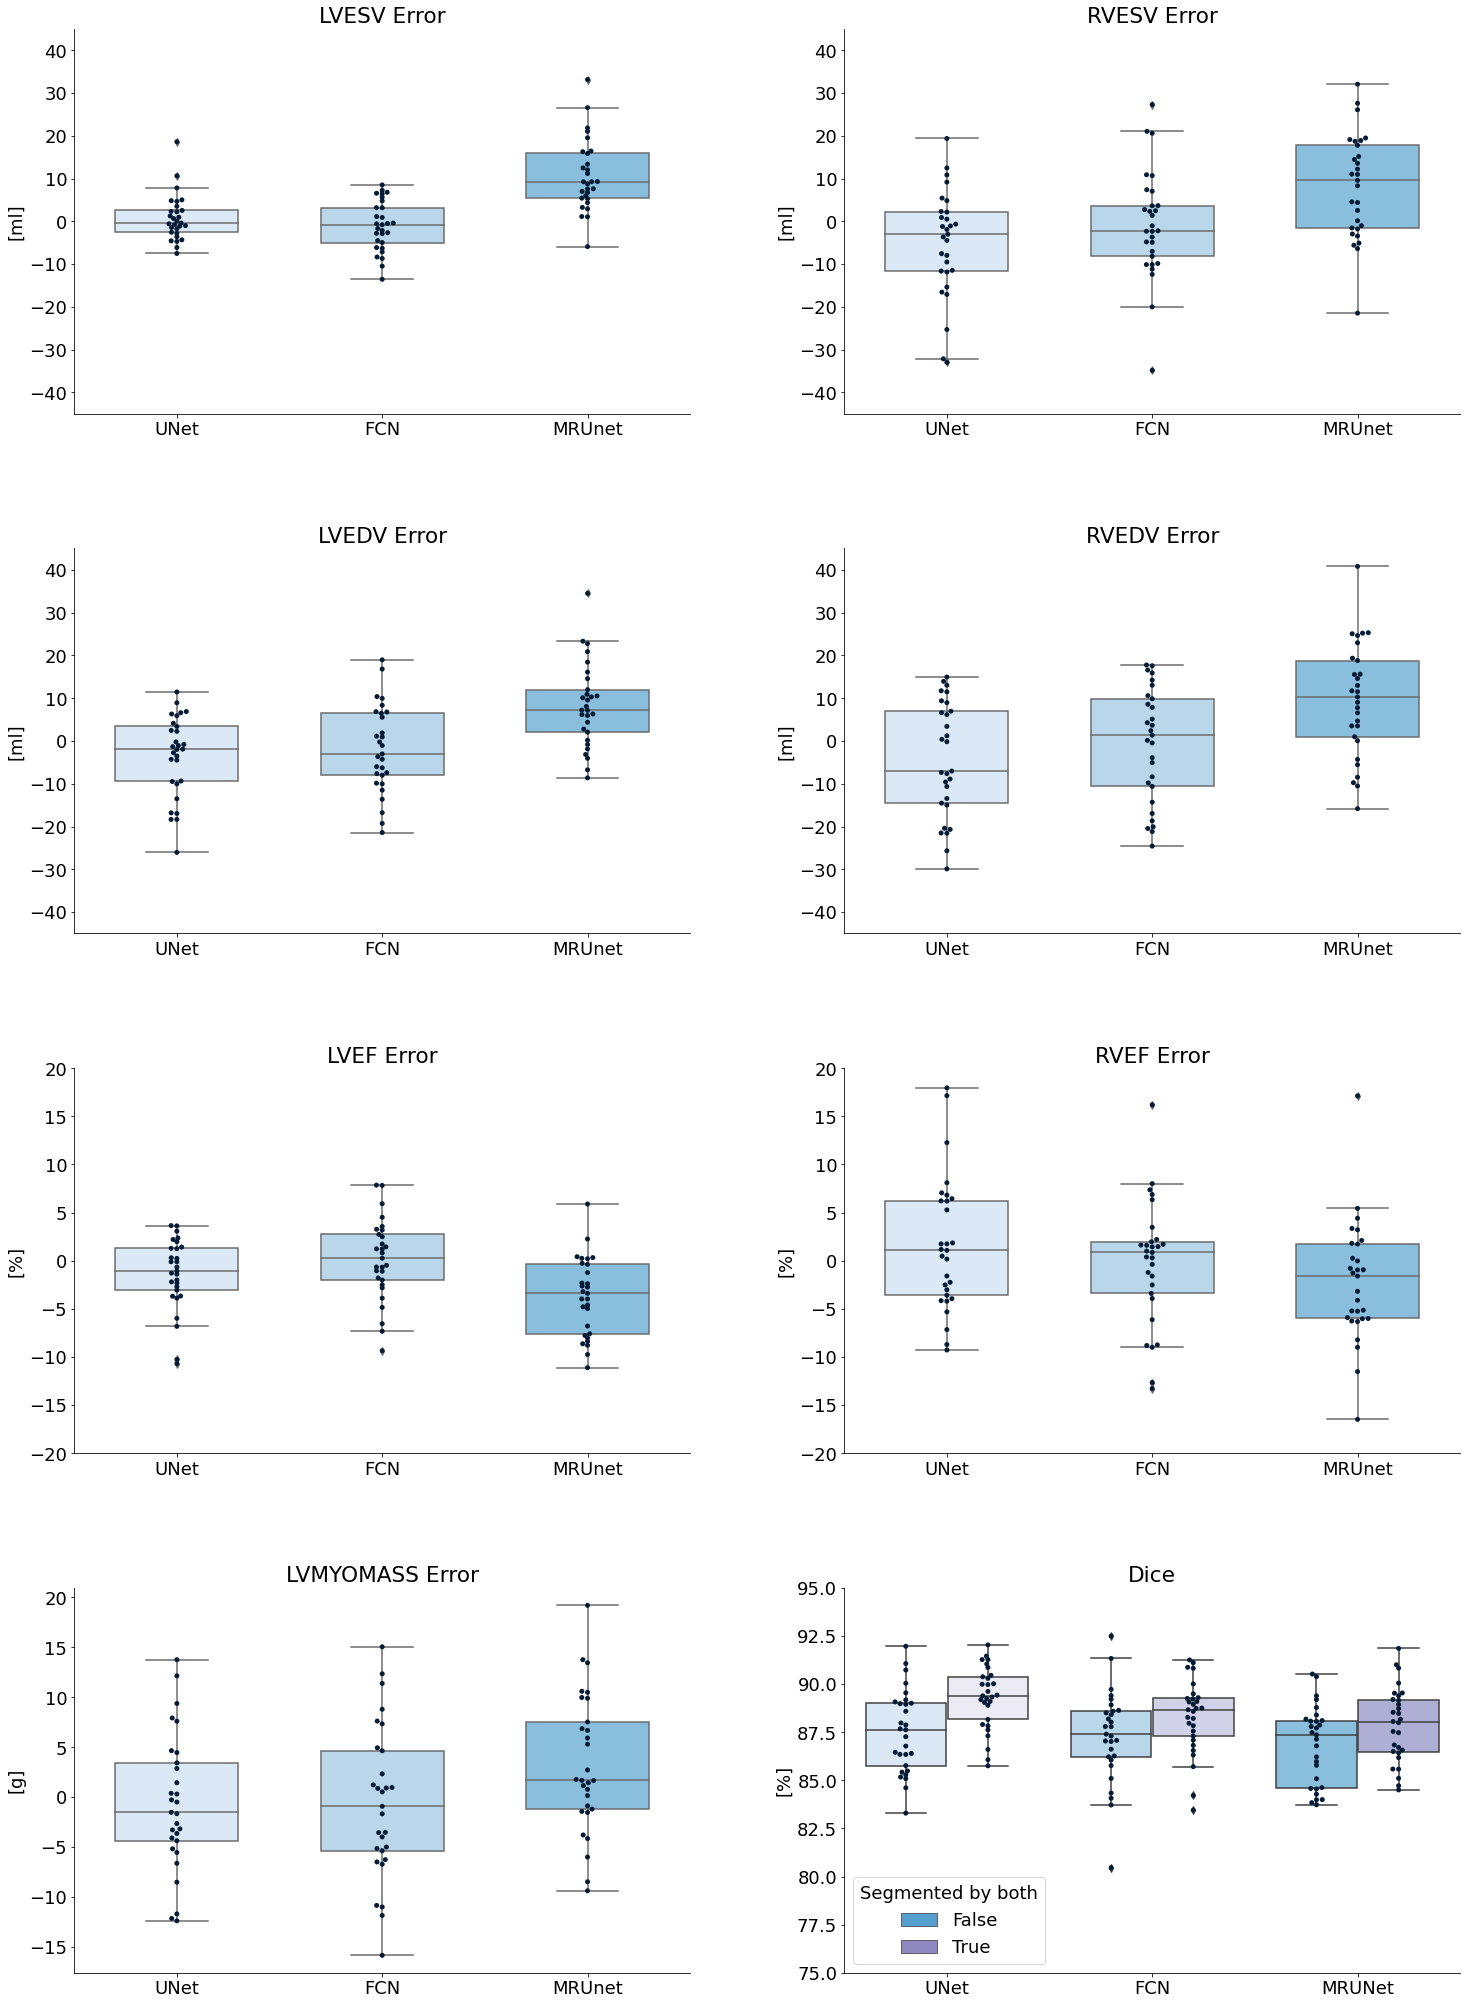

In [9]:
SAX_candlelight_plot(cases1, {'UNet':cases4, 'FCN':cases2, 'MRUnet':cases3}, bp)

## Some random image comparisons

In [ ]:
# Just showing some images
for c1,c2 in zip(cases1, cases4):
    print(c1.case_name, c2.case_name)
    lves1, lved1 = [c for c in c1.categories if 'ES' in c.name][0], [c for c in c1.categories if 'ED' in c.name][0]
    cat2 = [c for c in c2.categories][0]
    esp, edp = lves1.phase, lved1.phase
    for d in range(lves1.nr_slices):
        for p in [esp, edp]:
            print('Slice: ', d, ',  Phase: ', p)
            img1, anno1 = lves1.get_img(d, p), lves1.get_anno(d, p)
            img2, anno2 = cat2 .get_img(d, p), cat2 .get_anno(d, p)
            #fig, axes = plt.subplots(1,5, figsize=(20,10))
            fig, axes = plt.subplots(1,3, figsize=(20,10))
            #for i in range(5): axes[i].imshow(img1,cmap='gray'); axes[i].axis('off')
            for i in range(3): axes[i].imshow(img1,cmap='gray'); axes[i].axis('off')
            anno1.plot_all_contour_outlines(axes[0])
            anno2.plot_all_contour_outlines(axes[1])
            #anno1.plot_cont_comparison(axes[2], anno2, 'lv_endo')
            #anno1.plot_cont_comparison(axes[3], anno2, 'lv_myo' )
            #anno1.plot_cont_comparison(axes[4], anno2, 'rv_endo')
            anno1.plot_cont_comparison(axes[2], anno2, 'lv_myo' )
            anno1.plot_cont_comparison(axes[2], anno2, 'rv_endo')
            fig.tight_layout()
            plt.show()
    break

## Find terrible segmentations

In [ ]:
metric = DiceMetric()
for c1,c2 in zip(cases1, cases4):
    cc = Case_Comparison(c1, c2)
    metric.set_case_comparison(cc)
    dice_dict = metric.calculate_all_vals(True)
    for sop, c in dice_dict.keys():
        if 0 < np.abs(dice_dict[(sop,c)]) < 65:
            print(c, 'dice: ', dice_dict[(sop,c)])
            img   = c1.get_img(sop)
            anno1 = c1.load_anno(sop)
            anno2 = c2.load_anno(sop)
            if not anno1.has_contour(c) or not anno2.has_contour(c): continue
            fig, ax = plt.subplots(1,1,figsize=(10,10))
            ax.imshow(img, interpolation='none', cmap='gray')
            anno1.plot_cont_comparison(ax, anno2, c)
            ax.axis('off')
            plt.show()

## Making metric by phase slice table

In [12]:
metric_names  = ['dice', 'hd', 'ml diff', 'by reader1', 'by reader2', 'position1', 'position2']
contour_names = ['lv_endo', 'lv_myo', 'rv_endo']
ph_names      = ['ES', 'ED']

column_names  = ['case name', 'reader1', 'reader2', 'slice']
column_names += [cn+' '+p+' '+mn for cn in contour_names for p in ph_names for mn in metric_names]
print(len(column_names))
print(column_names)

46
['case name', 'reader1', 'reader2', 'slice', 'lv_endo ES dice', 'lv_endo ES hd', 'lv_endo ES ml diff', 'lv_endo ES by reader1', 'lv_endo ES by reader2', 'lv_endo ES position1', 'lv_endo ES position2', 'lv_endo ED dice', 'lv_endo ED hd', 'lv_endo ED ml diff', 'lv_endo ED by reader1', 'lv_endo ED by reader2', 'lv_endo ED position1', 'lv_endo ED position2', 'lv_myo ES dice', 'lv_myo ES hd', 'lv_myo ES ml diff', 'lv_myo ES by reader1', 'lv_myo ES by reader2', 'lv_myo ES position1', 'lv_myo ES position2', 'lv_myo ED dice', 'lv_myo ED hd', 'lv_myo ED ml diff', 'lv_myo ED by reader1', 'lv_myo ED by reader2', 'lv_myo ED position1', 'lv_myo ED position2', 'rv_endo ES dice', 'rv_endo ES hd', 'rv_endo ES ml diff', 'rv_endo ES by reader1', 'rv_endo ES by reader2', 'rv_endo ES position1', 'rv_endo ES position2', 'rv_endo ED dice', 'rv_endo ED hd', 'rv_endo ED ml diff', 'rv_endo ED by reader1', 'rv_endo ED by reader2', 'rv_endo ED position1', 'rv_endo ED position2']


In [20]:
def get_position(case, d, p, cont_name):
    cat  = case.categories[0]
    anno = cat.get_anno(d, p)
    has_cont = anno.has_contour(cont_name)
    if not has_cont:                    return 'outside'
    if has_cont and d==0:               return 'basal'
    if has_cont and d==cat.nr_slices-1: return 'apical'
    prev_has_cont = cat.get_anno(d-1, p).has_contour(cont_name)
    next_has_cont = cat.get_anno(d+1, p).has_contour(cont_name)
    if prev_has_cont and next_has_cont: return 'midv'
    if prev_has_cont and not next_has_cont: return 'apical'
    if not prev_has_cont and next_has_cont: return 'basal'

    
def metrics_phase_slice_table(cases1, cases2, fixed_phase_first_reader=False):
    dsc, hd, mld = DiceMetric(), HausdorffMetric(), mlDiffMetric()
    metrics = [dsc.get_val, hd.get_val, mld.get_val, lambda g1,g2,_: not g1.is_empty, lambda g1,g2,_: not g2.is_empty]
    view = SAX_CINE_View()
    row_dict = {}
    row_counter = 0
    for c1,c2 in zip(cases1, cases2):
        cc = Case_Comparison(c1,c2)
        nr_slices = c1.categories[0].nr_slices
        for sl_nr in range(nr_slices):
            row = [c1.case_name if sl_nr==0 else '', c1.reader_name, c2.reader_name,  sl_nr]
            for cont in contour_names:
                cat_es1, cat_ed1 = view.get_categories(c1, cont)
                cat_es2, cat_ed2 = view.get_categories(c2, cont)
                p_es1, p_ed1 = cat_es1.phase, cat_ed1.phase 
                p_es2, p_ed2 = (p_es1, p_ed1) if fixed_phase_first_reader else (cat_es2.phase, cat_ed2.phase)
                for cat1, cat2 in zip([cat_es1, cat_ed1],[cat_es2, cat_ed2]):
                    p1, p2 = cat1.phase, cat1.phase if fixed_phase_first_reader else cat2.phase
                    dcm = cat1.get_dcm(sl_nr, p1)
                    cont1, cont2 = cat1.get_anno(sl_nr, p1).get_contour(cont), cat2.get_anno(sl_nr, p2).get_contour(cont)
                    for m in metrics: 
                        if p1 is None or p2 is None: row.append('')
                        else: row.append(m(cont1, cont2, dcm))
                    row.extend([get_position(c1, sl_nr, p1, cont), get_position(c2, sl_nr, p2, cont)])
            row_dict['row_'+str(row_counter).zfill(5)] = row
            row_counter +=1 
    df = pandas.DataFrame.from_dict(row_dict, orient='index', columns=column_names)
    return df
table = metrics_phase_slice_table(cases1, cases4, fixed_phase_first_reader=True)

In [21]:
#display(table)
print(os.path.join(bp, 'metrics_slicephase_table.csv'))
pandas.DataFrame.to_csv(table, os.path.join(bp, 'metrics_slicephase_table_3.csv'), sep=';', decimal=',')

/media/omega/Daten1/CATCH/CS/metrics_slicephase_table.csv


## Metric Plots